/opt/anaconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:406: UserWarning: Found islands (degree-0 nodes). Indices of islands: {91}
  warnings.warn(


Ideal population per district: 14631.72
All districts are within the population bounds (30% tolerance).
Initial partition Democratic vote percentages: [0.6795282224094356, 0.6786759738797569, 0.7371464291295515, 0.6744542320949828, 0.742525501231094]...
Initial number of Democratic-won districts: 63
Short Chain - Step 0/10000
Short Chain - Step 1000/10000
Short Chain - Step 2000/10000
Short Chain - Step 3000/10000
Short Chain - Step 4000/10000
Short Chain - Step 5000/10000
Short Chain - Step 6000/10000
Short Chain - Step 7000/10000
Short Chain - Step 8000/10000
Short Chain - Step 9000/10000

Short Chain Results Summary:
Average number of cut edges: 610
Average number of majority-Latino districts: 6
Average number of Democratic-won districts: 65


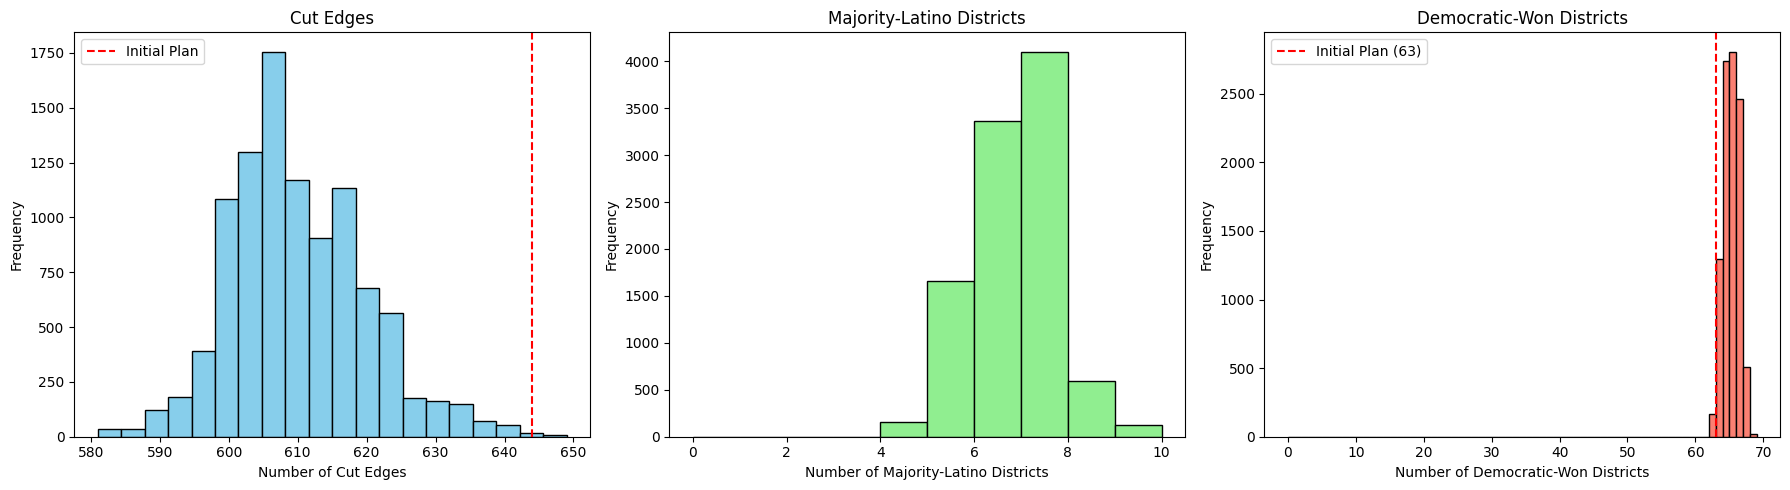

Time taken: 0.16 minutes


In [1]:
import geopandas as gpd
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain
from gerrychain.updaters import cut_edges, Tally, Election
from gerrychain.proposals import recom
from functools import partial
import time
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Record start time
start_time = time.time()

# Load the Rhode Island shapefile
ri_gdf = gpd.read_file("./RI/RI.shp")

# Convert GeoDataFrame to GerryChain Graph
ri_graph = Graph.from_geodataframe(ri_gdf, ignore_errors=True)

# Define updaters
updaters_dict = {
    "population": Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    "latino_population": Tally("HISP", alias="latino_population"),
    "pres_2020": Election("pres_2020", {"Democratic": "G20PRED", "Republican": "G20PRER"})
}

# Initial partition
initial_partition = Partition(
    graph=ri_graph,
    assignment="SEND",
    updaters=updaters_dict
)

# Check population
district_populations = initial_partition["population"]
ideal_population = sum(district_populations.values()) / len(district_populations)
print(f"Ideal population per district: {ideal_population}")

lower_bound = ideal_population * 0.70
upper_bound = ideal_population * 1.30
out_of_bounds = {district: pop for district, pop in district_populations.items() 
                 if pop < lower_bound or pop > upper_bound}

if out_of_bounds:
    print("\nDistricts with populations out of bounds (30% tolerance):")
    for district, pop in out_of_bounds.items():
        print(f"District {district}: {pop} (Should be between {lower_bound} and {upper_bound})")
else:
    print("All districts are within the population bounds (30% tolerance).")

# Validate initial partition
dem_percents = initial_partition["pres_2020"].percents("Democratic")
print(f"Initial partition Democratic vote percentages: {list(dem_percents)[:5]}...")
initial_dem_wins = sum(1 for percent in dem_percents if percent > 0.5)
print(f"Initial number of Democratic-won districts: {initial_dem_wins}")

# ReCom proposal
recom_proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=0.50,
    node_repeats=10
)

# Constraints
population_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.30)

# Function to run a short chain
def run_short_chain(steps, label):
    chain = MarkovChain(
        proposal=recom_proposal,
        constraints=[population_constraint],
        accept=accept.always_accept,
        initial_state=initial_partition,
        total_steps=steps
    )
    
    cut_edges_data = []
    latino_majority_districts = []
    dem_won_districts = []
    
    for step, partition in enumerate(chain):
        if step % 1000 == 0:
            print(f"{label} - Step {step}/{steps}")
        
        cut_edges_data.append(len(partition["cut_edges"]))
        latino_counts = partition["latino_population"]
        population_counts = partition["population"]
        latino_majority_count = sum(1 for district in latino_counts if latino_counts[district] > 0.5 * population_counts[district])
        latino_majority_districts.append(latino_majority_count)
        dem_wins = sum(1 for percent in partition["pres_2020"].percents("Democratic") if percent > 0.5)
        dem_won_districts.append(dem_wins)
    
    return pd.DataFrame({
        "Cut Edges": cut_edges_data,
        "Majority-Latino Districts": latino_majority_districts,
        "Democratic-Won Districts": dem_won_districts
    })

# Run a short chain of 10000 steps
total_steps_short = 10000
short_chain_data = run_short_chain(total_steps_short, "Short Chain")

# Print summary
print("\nShort Chain Results Summary:")
print(f"Average number of cut edges: {short_chain_data['Cut Edges'].mean():.0f}")
print(f"Average number of majority-Latino districts: {short_chain_data['Majority-Latino Districts'].mean():.0f}")
print(f"Average number of Democratic-won districts: {short_chain_data['Democratic-Won Districts'].mean():.0f}")

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(short_chain_data["Cut Edges"], bins=20, color="skyblue", edgecolor="black")
axes[0].set_title("Cut Edges")
axes[0].set_xlabel("Number of Cut Edges")
axes[0].set_ylabel("Frequency")
axes[0].axvline(x=len(initial_partition["cut_edges"]), color="red", linestyle="--", label="Initial Plan")
axes[0].legend()

axes[1].hist(short_chain_data["Majority-Latino Districts"], bins=range(max(short_chain_data["Majority-Latino Districts"].max(), 1) + 2), 
             color="lightgreen", edgecolor="black")
axes[1].set_title("Majority-Latino Districts")
axes[1].set_xlabel("Number of Majority-Latino Districts")
axes[1].set_ylabel("Frequency")

axes[2].hist(short_chain_data["Democratic-Won Districts"], bins=range(max(short_chain_data["Democratic-Won Districts"].max(), 1) + 2), 
             color="salmon", edgecolor="black")
axes[2].set_title("Democratic-Won Districts")
axes[2].set_xlabel("Number of Democratic-Won Districts")
axes[2].set_ylabel("Frequency")
axes[2].axvline(x=initial_dem_wins, color="red", linestyle="--", label=f"Initial Plan ({initial_dem_wins})")
axes[2].legend()

plt.tight_layout()
plt.savefig("histograms_short_ri.png")
plt.show()

# Record end time
end_time = time.time()
print(f"Time taken: {(end_time - start_time)/60:.2f} minutes")